**Reinforcement Learning with TensorFlow & TRFL: Deep Q Network Modifications**

In this notebook we modify a DQN with Double Q learning, Persistent Q learning, and Huber loss.

Outline:
1. Introduce Double Q learning and example
2. Introduce Persistent Q learning and example
3. Introduce Huber loss explanation and example




In [0]:
#TRFL works with TensorFlow 1.12
#installs TensorFlow version 1.12 then restarts the runtime
!pip install tensorflow==1.12

import os
os.kill(os.getpid(), 9)

In [1]:
#install tensorflow-probability 0.5.0 that works with TensorFlow 1.12
!pip install tensorflow-probability==0.5.0

#install TRFL
!pip install trfl


In [0]:
import gym
import tensorflow as tf
import numpy as np

** Double Q Learning **

Double Q learning tries to lessen approximation error by reducing overestimization bias found in Q learning. The overestimization bias is due to Q learning taking the max of next state Q values. Double Q learning attemps to lessen this error by using the argmax of the train network's next state Q values with the next state Q values of the target network. 

DQN update: 

TD target = R + 𝛄max_a(Qtarget(s’,a))

Double DQN update: 

TD target = R + 𝛄Qtarget(s’, argmax_a(Qtrain(s’,a))





In [0]:
# some of the TensorFlow code is this notebook is modified from this repo: https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb

import trfl

class QNetwork:
    def __init__(self, name, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20):
      
        with tf.variable_scope(name):
            #set up tensors
            self.input_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.action_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            self.targetQ_ = tf.placeholder(tf.float32, [batch_size, action_size], name='target')
            self.trainQ_next_ = tf.placeholder(tf.float32, [batch_size, action_size], name='trainQ_next')
            self.reward_ = tf.placeholder(tf.float32,[batch_size],name="reward")
            self.discount_ = tf.constant(0.99,shape=[batch_size],dtype=tf.float32,name="discount")
            self.name = name
   
            #This is the Neural Network. For CNN implementation, the input would feed into a CNN layer prior to these layers.
            self.fc1 = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.relu)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size, activation_fn=tf.nn.relu)
            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)

            #TRFL double qlearning
            qloss, q_learning = trfl.double_qlearning(self.output, self.action_, self.reward_, 
                                                      self.discount_, self.targetQ_, self.trainQ_next_)
            self.loss = tf.reduce_mean(qloss)
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
    def get_qnetwork_variables(self):
      return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]

** TRFL Usage **

Double Q learning usage is similar to trfl.qlearning. trfl.double_qlearning contains an addition function parameter marked above as self.trainQ_next_. The self.trainQ_next_ values are the train network's estimated Q values for the next state. We find the argmax of those values then use that argmax with the target network's Q values for the next state.

In the tf.Session() in a cell below, note that we need to create one more tensor than we did for trfl.qlearning. We create the output of the train network for the next state (the next state Q values) and input that into the feed dict when training the train network.

In [0]:
# define hyperparameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# epsilon greedy parameters
epsilon_start = 1.0            # exploration probability at start
epsilon_min = 0.01             # minimum exploration probability
epsilon_step = (epsilon_start-epsilon_min)/train_episodes

# network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

# how often in steps to update target network 
update_target_every = 2000

#declare TRFL in graph
tf.reset_default_graph()
trainQN = QNetwork(name='train_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)
targetQN = QNetwork(name='target_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)

#target network updating
target_network_update_ops = trfl.update_target_variables(targetQN.get_qnetwork_variables(), 
                                                         trainQN.get_qnetwork_variables(), tau=1.0/update_target_every)


In [0]:
from collections import deque

class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]
      
# Initialize the simulation
env = gym.make("CartPole-v0")
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [6]:
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    epsilon = 1.0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        # stop training when agent is consistently getting high rewards
        if len(rewards_list) > 9 and np.mean(rewards_list[-10:],axis=0)[1] > 195:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(rewards_list[-10:],axis=0)[1]))
          break
        while t < max_steps:
            step += 1
            
            # update target q network
            sess.run(target_network_update_ops)
            
            # epsilon greedy exploration
            if np.random.rand() <= epsilon:
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {trainQN.input_: state.reshape((1, *state.shape))}
                action_values = sess.run(trainQN.output, feed_dict=feed)
                action = np.argmax(action_values)
            
            # take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                if ep % 10 == 0:
                  print('Episode: {}'.format(ep),
                        'Total reward: {}'.format(total_reward),
                        'Training loss: {:.4f}'.format(loss),
                        'Epsilon: {:.4f}'.format(epsilon))
                rewards_list.append((ep, total_reward))
                
                
                # add experience to memory
                memory.add((state, action, reward, next_state))
                
                # start new episode
                env.reset()
                # take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

                # epsilon greedy exploration
                epsilon -= epsilon_step
                if epsilon < epsilon_min:
                  epsilon = epsilon_min
                  
            else:
                # add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # train network
            # get target Q values for next state
            target_Qs = sess.run(targetQN.output, feed_dict={targetQN.input_: next_states})
            # set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            # in Double Q learning, also need train network's Q values for next state
            train_Qs = sess.run(trainQN.output, feed_dict={trainQN.input_: next_states})
            # set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            train_Qs[episode_ends] = (0, 0)
            
            # TRFL way, calculate td_error within TRFL
            loss, _ = sess.run([trainQN.loss, trainQN.opt],
                                feed_dict={trainQN.input_: states,
                                           trainQN.targetQ_: target_Qs,
                                           trainQN.reward_: rewards,
                                           trainQN.action_: actions,
                                           trainQN.trainQ_next_: train_Qs})

Episode: 10 Total reward: 24.0 Training loss: 0.2110 Epsilon: 0.9911
Episode: 20 Total reward: 15.0 Training loss: 0.1204 Epsilon: 0.9812
Episode: 30 Total reward: 12.0 Training loss: 0.0270 Epsilon: 0.9713
Episode: 40 Total reward: 25.0 Training loss: 0.0124 Epsilon: 0.9614
Episode: 50 Total reward: 31.0 Training loss: 0.0054 Epsilon: 0.9515
Episode: 60 Total reward: 22.0 Training loss: 0.0080 Epsilon: 0.9416
Episode: 70 Total reward: 31.0 Training loss: 0.0013 Epsilon: 0.9317
Episode: 80 Total reward: 13.0 Training loss: 0.0010 Epsilon: 0.9218
Episode: 90 Total reward: 17.0 Training loss: 0.0014 Epsilon: 0.9119
Episode: 100 Total reward: 26.0 Training loss: 0.0084 Epsilon: 0.9020
Episode: 110 Total reward: 11.0 Training loss: 0.0028 Epsilon: 0.8921
Episode: 120 Total reward: 39.0 Training loss: 0.0041 Epsilon: 0.8822
Episode: 130 Total reward: 58.0 Training loss: 0.0043 Epsilon: 0.8723
Episode: 140 Total reward: 21.0 Training loss: 0.0046 Epsilon: 0.8624
Episode: 150 Total reward: 7.

Text(0, 0.5, 'Total Reward')

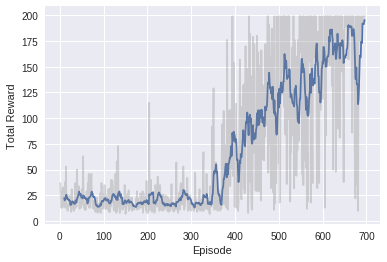

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

** Persistent Q Learning **

Persistent Q learning is another method to reduce approximation error. The authors of the method focus on maximizing the action gap. The action gap is the difference between the optimal and second best action. The key idea is persistence in actions:* “encourage greedy policies which infrequently switch between actions.”* The formula weighs TD target partially with the greedy Q value in the next state and partially with the Q value of the same action in next state. The original paper uses term *persistent advantage learning*. We'll have more on advantages in later sections.

DQN Q learning: 

TD target = R + 𝛄max_a(Qtarget(s’,a))

DQN Persistent Q learning: 

TD target = R + 𝛄 ((1-g)\*max_a(Qtarget(s’,a) + g\*Qtarget(s’, a’))


In [0]:
class QNetwork:
    def __init__(self, name, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20):
        with tf.variable_scope(name):
            #set up tensors
            self.input_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.action_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            self.targetQ_ = tf.placeholder(tf.float32, [batch_size, action_size], name='target')
            self.reward_ = tf.placeholder(tf.float32,[batch_size],name="reward")
            self.discount_ = tf.constant(0.99,shape=[batch_size],dtype=tf.float32,name="discount")
            self.name = name
   
            #This is the Neural Network. For CNN implementation, the input would feed into a CNN layer prior to these layers.
            self.fc1 = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.relu)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size, activation_fn=tf.nn.relu)
            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)

            #TRFL persistent qlearning
            qloss, qextra = trfl.persistent_qlearning(self.output, self.action_, self.reward_, 
                                                      self.discount_, self.targetQ_, action_gap_scale=0.5)
            self.loss = tf.reduce_mean(qloss)
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
    def get_qnetwork_variables(self):
      return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]

** TRFL Usage **

Same inputs as trfl.qlearning except an additional action_gap_scale argument (which defaults to 0.5). Note how easily TRFL makes it to switch between these three types of Q learning.

In [0]:
# define hyperparameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# epsilon greedy parameters
epsilon_start = 1.0            # exploration probability at start
epsilon_min = 0.01             # minimum exploration probability
epsilon_step = (epsilon_start-epsilon_min)/train_episodes

# network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

# how often in steps to update target network 
update_target_every = 2000

#declare TRFL in graph
tf.reset_default_graph()
trainQN = QNetwork(name='train_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)
targetQN = QNetwork(name='target_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)

#target network updating
target_network_update_ops = trfl.update_target_variables(targetQN.get_qnetwork_variables(), 
                                                         trainQN.get_qnetwork_variables(),tau=1.0/update_target_every)

In [0]:
# Initialize the simulation
env = gym.make("CartPole-v0")
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [11]:
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    epsilon = 1.0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        # stop training when agent is consistently getting high rewards
        if len(rewards_list) > 9 and np.mean(rewards_list[-10:],axis=0)[1] > 195:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep,np.mean(rewards_list[-10:],axis=0)[1]))
          break
        while t < max_steps:
            step += 1
            
            # update target q network
            sess.run(target_network_update_ops)
            
            # epsilon greedy exploration
            if np.random.rand() <= epsilon:
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {trainQN.input_: state.reshape((1, *state.shape))}
                action_values = sess.run(trainQN.output, feed_dict=feed)
                action = np.argmax(action_values)
            
            # take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                if ep % 10 == 0:
                  print('Episode: {}'.format(ep),
                        'Total reward: {}'.format(total_reward),
                        'Training loss: {:.4f}'.format(loss),
                        'Epsilon: {:.4f}'.format(epsilon))
                rewards_list.append((ep, total_reward))
                
                
                # add experience to memory
                memory.add((state, action, reward, next_state))
                
                # start new episode
                env.reset()
                # take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

                # epsilon greedy exploration
                epsilon -= epsilon_step
                if epsilon < epsilon_min:
                  epsilon = epsilon_min
                  
            else:
                # add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # train network
            # get target Q values for next state
            target_Qs = sess.run(targetQN.output, feed_dict={targetQN.input_: next_states})
            # set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            # in Double Q learning, also need train network's Q values for next state
            train_Qs = sess.run(trainQN.output, feed_dict={trainQN.input_: next_states})

            # TRFL way, calculate td_error within TRFL
            loss, _ = sess.run([trainQN.loss, trainQN.opt],
                                feed_dict={trainQN.input_: states,
                                           trainQN.targetQ_: target_Qs,
                                           trainQN.reward_: rewards,
                                           trainQN.action_: actions})

Episode: 10 Total reward: 23.0 Training loss: 0.2802 Epsilon: 0.9911
Episode: 20 Total reward: 22.0 Training loss: 0.0695 Epsilon: 0.9812
Episode: 30 Total reward: 14.0 Training loss: 0.0885 Epsilon: 0.9713
Episode: 40 Total reward: 12.0 Training loss: 0.0270 Epsilon: 0.9614
Episode: 50 Total reward: 10.0 Training loss: 0.0156 Epsilon: 0.9515
Episode: 60 Total reward: 13.0 Training loss: 0.0034 Epsilon: 0.9416
Episode: 70 Total reward: 32.0 Training loss: 0.0089 Epsilon: 0.9317
Episode: 80 Total reward: 19.0 Training loss: 0.0020 Epsilon: 0.9218
Episode: 90 Total reward: 17.0 Training loss: 0.0013 Epsilon: 0.9119
Episode: 100 Total reward: 17.0 Training loss: 0.0014 Epsilon: 0.9020
Episode: 110 Total reward: 41.0 Training loss: 0.0022 Epsilon: 0.8921
Episode: 120 Total reward: 15.0 Training loss: 0.0007 Epsilon: 0.8822
Episode: 130 Total reward: 14.0 Training loss: 0.0042 Epsilon: 0.8723
Episode: 140 Total reward: 15.0 Training loss: 0.0042 Epsilon: 0.8624
Episode: 150 Total reward: 29

Text(0, 0.5, 'Total Reward')

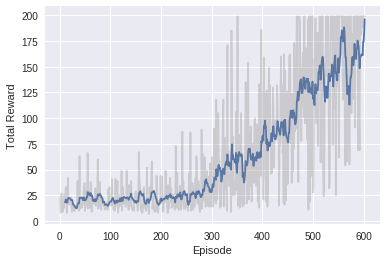

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

** Huber Loss **

Huber loss is less sensitive to outliers than squared loss. Huber loss is similar to squared loss where the estimate is close to target and linear elsewhere.


In [0]:
class QNetwork:
    def __init__(self, name, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20):
        with tf.variable_scope(name):
            #set up tensors
            self.input_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.action_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            self.targetQ_ = tf.placeholder(tf.float32, [batch_size, action_size], name='target')
            self.reward_ = tf.placeholder(tf.float32,[batch_size],name="reward")
            self.discount_ = tf.constant(0.99,shape=[batch_size],dtype=tf.float32,name="discount")
            self.name = name
   
            #This is the Neural Network. For CNN implementation, the input would feed into a CNN layer prior to these layers.
            self.fc1 = tf.contrib.layers.fully_connected(self.input_, hidden_size, activation_fn=tf.nn.relu)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size, activation_fn=tf.nn.relu)
            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)

            #TRFL persistent qlearning
            qloss, qextra = trfl.persistent_qlearning(self.output, self.action_, self.reward_, 
                                                      self.discount_, self.targetQ_, action_gap_scale=0.5)
            self.losses = trfl.huber_loss(qextra.td_error,1.0)
            self.loss = tf.reduce_mean(self.losses)
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
    def get_qnetwork_variables(self):
      return [t for t in tf.trainable_variables() if t.name.startswith(self.name)]
   

** TRFL USAGE **

trfl.huber_loss() takes the TD error from trfl.qlearning (or any other compatible function that outputs the difference between the target and estimated value) as an input. The second parametrer is the hyperparameter delta (1.0 in this case) that determines the break point where Huber loss switches from squared loss to linear loss.

In [0]:
# define hyperparameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# epsilon greedy parameters
epsilon_start = 1.0            # exploration probability at start
epsilon_min = 0.01             # minimum exploration probability
epsilon_step = (epsilon_start-epsilon_min)/train_episodes

# network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

# how often in steps to update target network 
update_target_every = 2000

#declare TRFL in graph
tf.reset_default_graph()
trainQN = QNetwork(name='train_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)
targetQN = QNetwork(name='target_qn', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)

#target network updating
target_network_update_ops = trfl.update_target_variables(targetQN.get_qnetwork_variables(), 
                                                         trainQN.get_qnetwork_variables(), tau=1.0/update_target_every)

In [0]:
# Initialize the simulation
env = gym.make("CartPole-v0")
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [16]:
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    epsilon = 1.0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        # stop training when agent is consistently getting high rewards
        if len(rewards_list) > 9 and np.mean(rewards_list[-10:],axis=0)[1] > 195:
          print("Stopping at episode {} with average rewards of {} in last 10 episodes".
                format(ep, np.mean(rewards_list[-10:],axis=0)[1]))
          break
        while t < max_steps:
            step += 1
            
            # update target q network
            sess.run(target_network_update_ops)
            
            # epsilon greedy exploration
            if np.random.rand() <= epsilon:
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {trainQN.input_: state.reshape((1, *state.shape))}
                action_values = sess.run(trainQN.output, feed_dict=feed)
                action = np.argmax(action_values)
            
            # take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                if ep % 10 == 0:
                  print('Episode: {}'.format(ep),
                        'Total reward: {}'.format(total_reward),
                        'Training loss: {:.4f}'.format(loss),
                        'Epsilon: {:.4f}'.format(epsilon))
                rewards_list.append((ep, total_reward))
                
                
                # add experience to memory
                memory.add((state, action, reward, next_state))
                
                # start new episode
                env.reset()
                # take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

                # epsilon greedy exploration
                epsilon -= epsilon_step
                if epsilon < epsilon_min:
                  epsilon = epsilon_min
                  
            else:
                # add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # train network
            # get target Q values for next state
            target_Qs = sess.run(targetQN.output, feed_dict={targetQN.input_: next_states})
            # set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)

            # TRFL way, calculate td_error within TRFL
            loss, _ = sess.run([trainQN.loss, trainQN.opt],
                                feed_dict={trainQN.input_: states,
                                           trainQN.targetQ_: target_Qs,
                                           trainQN.reward_: rewards,
                                           trainQN.action_: actions})

Episode: 10 Total reward: 11.0 Training loss: 0.1179 Epsilon: 0.9911
Episode: 20 Total reward: 36.0 Training loss: 0.0296 Epsilon: 0.9812
Episode: 30 Total reward: 82.0 Training loss: 0.0136 Epsilon: 0.9713
Episode: 40 Total reward: 19.0 Training loss: 0.0045 Epsilon: 0.9614
Episode: 50 Total reward: 10.0 Training loss: 0.0037 Epsilon: 0.9515
Episode: 60 Total reward: 14.0 Training loss: 0.0022 Epsilon: 0.9416
Episode: 70 Total reward: 10.0 Training loss: 0.0027 Epsilon: 0.9317
Episode: 80 Total reward: 35.0 Training loss: 0.0006 Epsilon: 0.9218
Episode: 90 Total reward: 20.0 Training loss: 0.0208 Epsilon: 0.9119
Episode: 100 Total reward: 13.0 Training loss: 0.0029 Epsilon: 0.9020
Episode: 110 Total reward: 22.0 Training loss: 0.0047 Epsilon: 0.8921
Episode: 120 Total reward: 17.0 Training loss: 0.0102 Epsilon: 0.8822
Episode: 130 Total reward: 19.0 Training loss: 0.0063 Epsilon: 0.8723
Episode: 140 Total reward: 52.0 Training loss: 0.0024 Epsilon: 0.8624
Episode: 150 Total reward: 12

Text(0, 0.5, 'Total Reward')

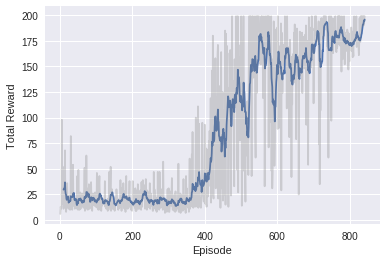

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')